In [1]:
import time
import itertools
from asteval import Interpreter
import numpy as np

import multiprocessing as mp
from multiprocessing import Pool

import matplotlib.pyplot as pl
import matplotlib as mpl
%matplotlib notebook

import astropy.units as u
import astropy.io.fits as fits
from astropy.utils.data import download_file
from astropy.nddata import StdDevUncertainty
from astropy.wcs import WCS
from astropy.modeling import fitting, Model, models

import astropy.modeling.models as models

from spectral_cube import SpectralCube

from specutils.fitting import fit_lines, _strip_units_from_model
from specutils.spectra import Spectrum1D, SpectralRegion
from specutils.manipulation import extract_region, _to_edge_pixel

## Read spectrum data

This is a 74 X 74 spatial image in which each spaxel represents a spectrum with 4563 data points.

In [2]:
# fn = download_file('https://data.sdss.org/sas/dr14/manga/spectro/redux/v2_1_2/7495/stack/manga-7495-12704-LOGCUBE.fits.gz', cache=True)
fn = download_file('file:/Users/busko/Desktop/manga-7495-12704-LOGCUBE.fits', cache=True)
f = fits.open(fn)

flux3d = f[1].data
err3d = f[2].data
wave = f[4].data

print(wave.shape)
print(flux3d.shape)
print(err3d.shape)

(4563,)
(4563, 74, 74)
(4563, 74, 74)


In [3]:
# Units handling is presumed to come from above, perhaps at the loader level?
# Here we pretend we got them already somehow
funit_string = f[1].header['BUNIT']
funit = u.def_unit(funit_string, 1.E-17 * u.erg/u.s/u.cm/u.cm/u.Angstrom)
u.add_enabled_units([funit])
wunit = u.Unit('Angstrom')

## Define central spaxel, and area around it

We can change the area to test improvements in speedup.

In [4]:
CENTER = 37
HSIZE = 2

## Initial fit

Fit the central spaxel to use the fit results as initial values for the subsequent fits over other spaxels. 

In here, we use the code from `Example_fitting.ipynb`.

In [5]:
flux = flux3d[:,CENTER,CENTER] * funit
err = err3d[:,CENTER,CENTER] * funit
wave = wave * wunit

spectrum_original = Spectrum1D(spectral_axis=wave, flux=flux, uncertainty=StdDevUncertainty(err))

# Limit to small wavelength region.
region = SpectralRegion(6500*wunit, 7000*wunit)

spectrum = extract_region(spectrum_original, region)

In [6]:
# Define model subcomponents
g1 = models.Gaussian1D(amplitude=0.7*funit, mean=6776.*wunit, stddev=3*wunit, name='g1')
g2 = models.Gaussian1D(amplitude=0.5*funit, mean=6755.*wunit, stddev=3*wunit, name='g2')
g3 = models.Gaussian1D(amplitude=0.4*funit, mean=6740.*wunit, stddev=3*wunit, name='g3')
zero_level = models.Const1D(amplitude=1.*funit, name='const1d')

# Build compound model to be used as intial guess
expression = "g1 + g2 + g3 + const1d"
model_dict = {g1.name:g1,
              g2.name:g2,
              g3.name:g3,
              zero_level.name:zero_level}
aeval = Interpreter(usersyms=model_dict)
compound_model_init = aeval(expression)

In [7]:
fitted_model_central = fit_lines(spectrum, compound_model_init)

### Check result

In [8]:
fitted_values = fitted_model_central(spectrum.spectral_axis)
fitted_spectrum = Spectrum1D(spectral_axis=spectrum.spectral_axis, flux=fitted_values*funit)

fitted_model_central

<CompoundModel(amplitude_0=0.89039809 1E-17 erg/s/cm^2/Angstrom/spaxel, mean_0=6776.3625129 Angstrom, stddev_0=2.9543515 Angstrom, amplitude_1=0.34599817 1E-17 erg/s/cm^2/Angstrom/spaxel, mean_1=6755.22049861 Angstrom, stddev_1=2.18754899 Angstrom, amplitude_2=0.31846185 1E-17 erg/s/cm^2/Angstrom/spaxel, mean_2=6739.42308924 Angstrom, stddev_2=3.24476625 Angstrom, amplitude_3=1.95308069 1E-17 erg/s/cm^2/Angstrom/spaxel)>

<IPython.core.display.Javascript object>


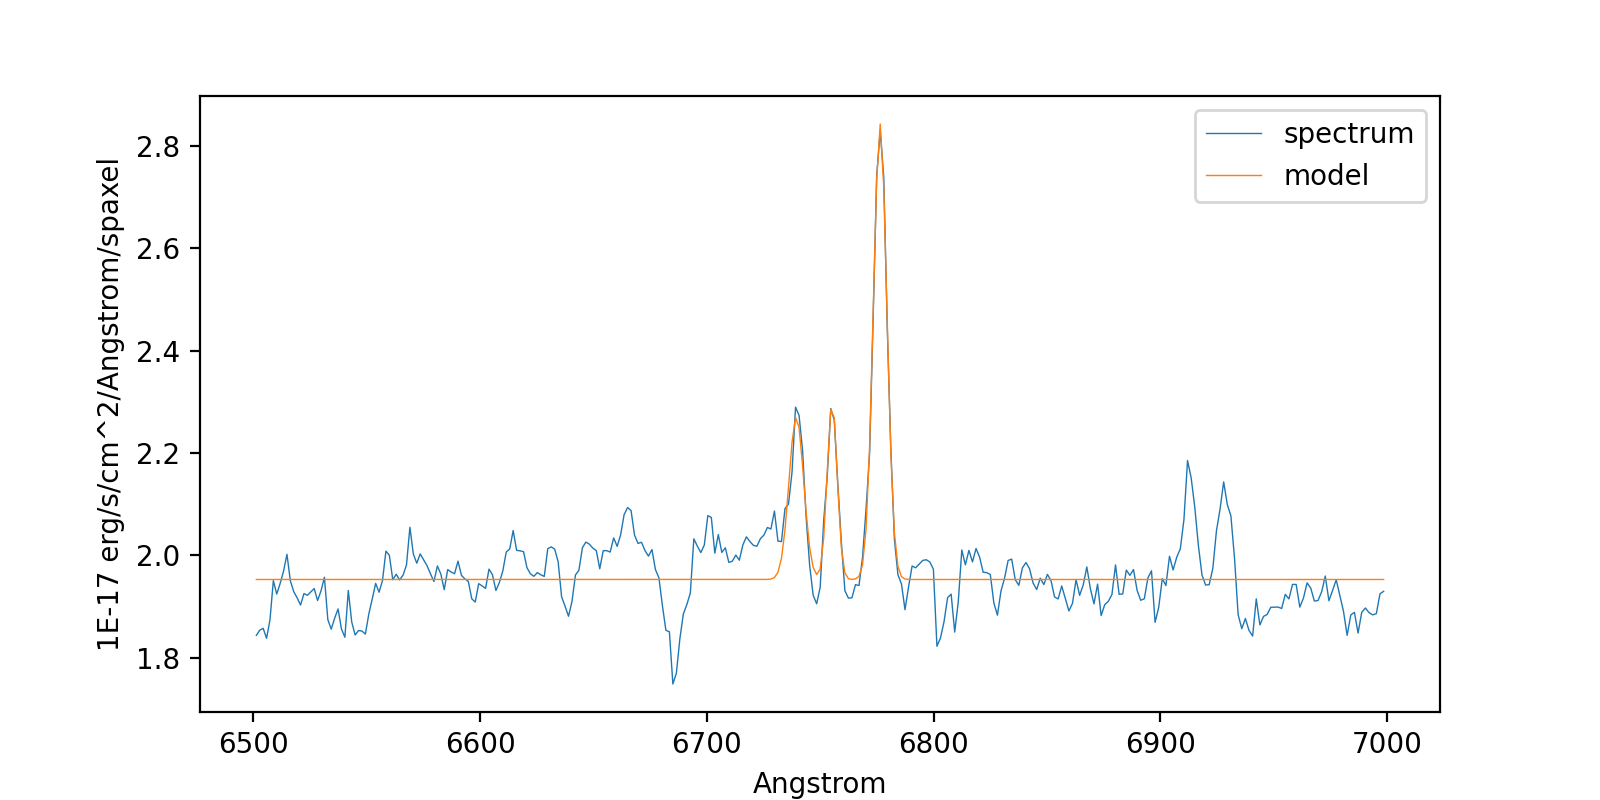

Text(0, 0.5, '1E-17 erg/s/cm^2/Angstrom/spaxel')

In [9]:
pl.figure()
pl.gcf().set_size_inches((8.,4.))
pl.plot(spectrum.spectral_axis, spectrum.flux, linewidth=0.5, label='spectrum')
pl.plot(spectrum.spectral_axis, fitted_values, linewidth=0.5, label='model')
pl.legend()
pl.xlabel(str(spectrum.spectral_axis.unit))
pl.ylabel(str(spectrum.flux.unit))

## Multi-spaxel fit

Lets try to fit a few spaxels around the center using the naive approcah of looping over the spaxels, building a `Spectrum1D` instance for each spaxel, and fitting them.

This is basically a timing experiment, so we don't care about storing the fit results.

In [10]:
# Generate list of all spaxels to be fitted
spx = [[(x,y) for x in range(CENTER-HSIZE, CENTER+HSIZE)] for y in range(CENTER-HSIZE, CENTER+HSIZE)]
spaxels = [item for sublist in spx for item in sublist]

In [11]:
# Find once and for all the indices corresponding to the 
# extracted region. Note that we use a hack to get the 
# indices of the extracted region. Then we use these indices 
# to slice the flux cube. This results in a significant speed 
# up overal.
region = SpectralRegion(6500*wunit, 7000*wunit)
spectrum = Spectrum1D(spectral_axis=wave, flux=flux3d[:, CENTER, CENTER] * funit)
i1, i2 = _to_edge_pixel(region.subregions[0], spectrum)

wave_r = wave[i1:i2]

# Main timing loop
t1 = time.time()
for x,y in spaxels:
    flux = flux3d[i1:i2, x, y] * funit
    spectrum = Spectrum1D(spectral_axis=wave_r, flux=flux)

    fitted_model_xy = fit_lines(spectrum, fitted_model_central)
        
#     print(x, y, fitted_model_xy.amplitude_0)
        
t2 = time.time() - t1 
t3 = t2 / (2*HSIZE+1)**2
print("Total time: ", t2, "s")
print("Time per spaxel:", t3, "s")

Total time:  1.6043369770050049 s
Time per spaxel: 0.0641734790802002 s


Now, to check if calling the `Spectrum1D` constructor for every single spaxel may incur in a penalty, we run the same test case, but using a single `Spectrum1D` instance intitalized with the flux cube.

In [12]:
# Find once and for all the indices corresponding to the extracted region
# (code repeated here for clarity). This results in a significant speed up.
# Due to a bug in extract_region when working with 3D data, we hack the 
# indices corresponding to the spectral region and use slicing afterwards. 
region = SpectralRegion(6500*wunit, 7000*wunit)
spectrum = Spectrum1D(spectral_axis=wave, flux=flux3d[:, CENTER, CENTER] * funit)
i1, i2 = _to_edge_pixel(region.subregions[0], spectrum)

# Slice to extract region
wave_r = wave[i1:i2]
flux3d_r = flux3d[i1:i2,:,:]

# Transpose the flux cube as per Spectrum1D requirement.
flux3d_r_transposed = flux3d_r.transpose(1,2,0)

# Build the 3D Spectrum1D instance.
spectrum = Spectrum1D(spectral_axis=wave_r, flux=flux3d_r_transposed * funit)

# Main timing loop
t1 = time.time() 
for x,y in spaxels:

    fitted_model_xy = fit_lines(spectrum[x,y], fitted_model_central)
        
#     print(x, y, fitted_model_xy.amplitude_0)
        
t2 = time.time() - t1
t3 = t2 / (2*HSIZE+1)**2
print("Total time: ", t2, "s")
print("Time per spaxel:", t3, "s")

Total time:  1.554610013961792 s
Time per spaxel: 0.06218440055847168 s


### Conclusion

There seems to be no penalty in calling the `Spectrum1D` constructor for every spaxel. The difference in execution times between the two approaches is of a few percent for cubes with up to 2500 spaxels.

This is actually important to know, for the reason that follows:

It hapens that passing a `Spectrum1D` instance to a multiprocess pool worker, prevents the worker from being called by the pool. The spectrum instance does not have even to participate in the actual execution, just a reference to it, if stored in the worker instance, somehow inhibits the worker from being called by the pool.

This was tested with the worker object as an instance of a class, as below, and also with the worker being a plain top level function to which the spectrum gets passed at every call. No difference. 

## Worker class

A class whose instances are callable. It provides the callable for the `Pool.apply_async` function, and also holds everything necessary to perform the fit over one spaxel.

In [13]:
class SpaxelWorker:
    def __init__(self, flux_cube, wave_array, initial_model):
        self.cube = flux_cube
        self.wave = wave_array
        self.model = initial_model
        
    def __call__(self, parameters):
        x = parameters[0]
        y = parameters[1]

        flux = self.cube[:, x, y] * funit
        sp = Spectrum1D(spectral_axis=self.wave, flux=flux)
        fitted_model = fit_lines(sp, self.model)
    
#         print(x, y, fitted_model.amplitude_0.value)
        
        return (x, y, fitted_model.amplitude_0.value)

## Multiprocess with worker pool

In [14]:
# Find once and for all the indices corresponding to the region to be
# extracted. Due to a bug in extract_region when working with 3D data, 
# we hack the indices corresponding to the spectral region and use slicing 
# afterwards.
# Extracting the desired wavelength region before we do anything else 
# results in a significant speed up of the loop over spaxels.
region = SpectralRegion(6500*wunit, 7000*wunit)
spectrum = Spectrum1D(spectral_axis=wave, flux=flux3d[:, CENTER, CENTER] * funit)
i1, i2 = _to_edge_pixel(region.subregions[0], spectrum)

wave_r = wave[i1:i2]
flux_cube_r = flux3d[i1:i2,:,:]

# Multiprocessing worker.
worker = SpaxelWorker(flux_cube_r, wave_r, fitted_model_central)

# Slab with results. We are collecting fitted values
# for one model parameter only. A different strategy 
# should be used to collect all parameter values for
# every spaxel. Maybe a cube? 
slab = np.zeros(shape=(flux3d.shape[1],flux3d.shape[2]))

# Callback to collect results from workers into the slab
def collect_result(result):
#     print(result)
    x = result[0]
    y = result[1]
    value = result[2]
    slab[x,y] = value

## Run pool

In [15]:
results = []
pool = Pool(mp.cpu_count() - 1)
t1 = time.time()  # timing
for spx in spaxels:
    r = pool.apply_async(worker, (spx,), callback=collect_result)
    results.append(r)
for r in results:
    r.wait()
t2 = time.time() - t1  # timing
t3 = t2 / (2*HSIZE+1)**2
print("Total time: ", t2, "s")
print("Time per spaxel:", t3, "s")

Total time:  0.5664219856262207 s
Time per spaxel: 0.022656879425048827 s


## Result

In [16]:
slab[CENTER-HSIZE:CENTER+HSIZE,CENTER-HSIZE:CENTER+HSIZE]

array([[0.50165703, 0.56567037, 0.60571987, 0.5695352 ],
       [0.58187524, 0.71320272, 0.7986674 , 0.76354989],
       [0.62536968, 0.79252945, 0.89039809, 0.83724674],
       [0.61333006, 0.72617945, 0.80158051, 0.74021777]])